#Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)



## Introducción
En este notebook se realizará un modelo de clasificación de imágenes por medio de un dataset que contempla una separación de animales, entre gatos y perros, se tomará en cuenta a su vez un modelo previamente fabricado por las personas de tensorflow para poder realizar una comparativa con un modelo hecho desde 0 


## **Instalación de librerías**


In [ ]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

Tambien utilizaremos pandas para poder tener una mejor visualización de los datos.

In [ ]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

## **Preparación del Dataset**

Conectamos nuestro notebook para extraer las imagenes de nuestro drive, con la finalidad de no tener que resubir las imagenes cada vez que se utilizán

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Entramos al folder que contiene todos nuestros archivos para entrenamiento y test

In [ ]:
%cd drive/MyDrive/DogsVSCat

/content/drive/MyDrive/DogsVSCat


In [ ]:
!ls

saved_models  test  test.zip  train  train.zip


In [ ]:
#!unzip train

In [ ]:
#!unzip test

In [ ]:
#%cd ..

Definimos el path hacía nuestros datos de entrenamiento

In [ ]:
data_root='/content/drive/My Drive/DogsVSCat/train';

Hacemos un datagenerator con la función de tensor flow de keras, en el cúal tambien definiremos el tamaño de nuestra imagen y separaremos los distintos subsets que se estarán utilizando, en este caso el de train y validación

In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

/content/drive/My Drive/DogsVSCat/train
Found 800 images belonging to 2 classes.
Found 3202 images belonging to 2 classes.


Revisamos que nuestros subsets se generen de forma adecuada, así como las etiquetas que recibirán estos

In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
['Gatos' 'Perros']


# Training

Utilizaremos un modelo pre fabricado a manera de transfer learning, el modelo será el MobileNet v2 model el cúal se encuentra en el TensorFlow Hub.

y cuenta con las siguientes especificaciones:

*   Input shape: 224x224x3 (224x224 pixels, 3 chanels each, RGB format),
*   Each channel has value in range [0, 1]

For more details check feature vector page: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4




In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Compilamos el modelo, con la función de perdida de "categorical_crossentropy", el optimizador "Adam" y las métricas 

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

*Entrenamos el modelo*

En esta ocasión utilizaremos 10 epocas, pondremos el set de validación para que nos indique las métricas necesarias

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/10
101/101 [==============================] - 372s 3s/step - loss: 0.1616 - accuracy: 0.9319 - val_loss: 0.0445 - val_accuracy: 0.9875
Epoch 2/10
101/101 [==============================] - 20s 194ms/step - loss: 0.0632 - accuracy: 0.9775 - val_loss: 0.0405 - val_accuracy: 0.9887
Epoch 3/10
101/101 [==============================] - 19s 185ms/step - loss: 0.0547 - accuracy: 0.9809 - val_loss: 0.0360 - val_accuracy: 0.9900
Epoch 4/10
101/101 [==============================] - 19s 187ms/step - loss: 0.0464 - accuracy: 0.9822 - val_loss: 0.0357 - val_accuracy: 0.9900
Epoch 5/10
101/101 [==============================] - 20s 194ms/step - loss: 0.0398 - accuracy: 0.9844 - val_loss: 0.0416 - val_accuracy: 0.9887
Epoch 6/10
101/101 [==============================] - 18s 183ms/step - loss: 0.0395 - accuracy: 0.9856 - val_loss: 0.0378 - val_accuracy: 0.9850
Epoch 7/10
101/101 [==============================] - 19s 192ms/step - loss: 0.0282 - accuracy: 0.9900 - val_loss: 0.0388 - val_accu

Revisamos por medio de gráficas como es el desempeño de nuestro modelo, comparando la precisión con el set de validación, así como la perdida.

[0.9319175481796265, 0.9775140285491943, 0.9809494018554688, 0.9821986556053162, 0.9843847751617432, 0.9856339693069458, 0.9900062680244446, 0.9896939396858215, 0.9878200888633728, 0.9906308650970459]
[0.987500011920929, 0.9887499809265137, 0.9900000095367432, 0.9900000095367432, 0.9887499809265137, 0.9850000143051147, 0.9900000095367432, 0.9850000143051147, 0.9912499785423279, 0.9862499833106995]


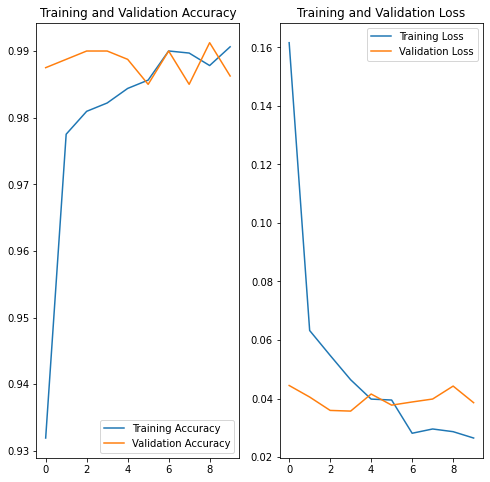

In [ ]:
acc = hist['accuracy']
print(hist['accuracy'])
print(hist['val_accuracy'])
val_acc = hist['val_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como podemos apreciar las gráficas nos podemos dar cuenta, de que el training así como el set de validación tienen muy buena precisión además de poca perdida, lo que sin duda es lo que buscamos 

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

25/25 [==============================] - 4s 151ms/step - loss: 0.0386 - accuracy: 0.9862
Final loss: 0.04
Final accuracy: 98.62%


# Exportamos el modelo


In [ ]:
ANIMAL_SAVED_MODEL = "saved_models/animal"
model.save(ANIMAL_SAVED_MODEL)

## Cargamos el modelo de TensorFlow (el cual previamente guardamos)


In [ ]:
from tensorflow import keras
# Load SavedModel

animal_model = keras.models.load_model(ANIMAL_SAVED_MODEL)

## Revisamos las predicciones con el subset de validación

In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


lo que nos dice el shape es que tenemos un batch de 32 imágenes, con tamaño y canales de: 224x224x3.

Realizamos una predicción 

In [ ]:
tf_model_predictions = animal_model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 [==============================] - 1s 524ms/step
Prediction results shape: (32, 2)


Realizamos la conversión de las predicciones en un data frame de pandas para revisar que es lo que está sucediendo 

In [ ]:
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Gatos,Perros
0,0.99999845,0.00000158
1,0.99932027,0.00067969
2,0.00000031,0.99999964
3,0.00061880,0.99938118
4,0.05305620,0.94694382


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

Lo que haremos a continuación será imprimir cuales fueron nuestras predicciones con sus respectivas imágenes

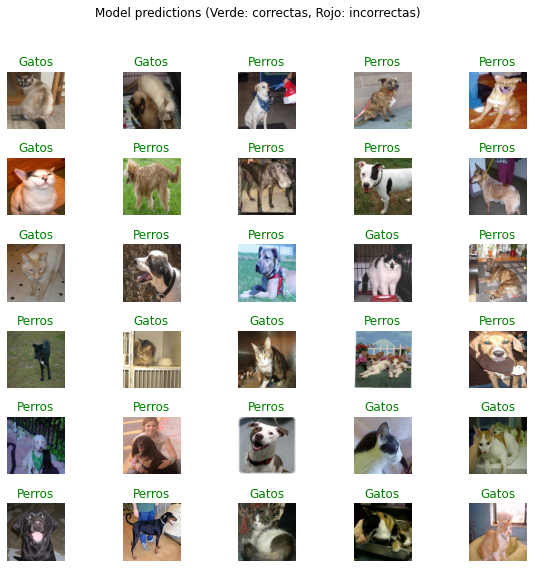

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (Verde: correctas, Rojo: incorrectas)")

Para el siguiente modelo intentaremos utilizar una capa de data augmentation, con la función de keras, que nos permitirá cambiar ciertos parámetros de las imágenes, teniendo así menores sesgos en nuestro entrenamiento 

In [ ]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

Probaremos con una serie de capas de convolución, así como max pooling y batch normalization, para ver los resultados de nuestro modelo, esto sin dejar de lado que utilizaremos a su vez en la capa final la función de activación de softmax para realizar la clasificación

In [ ]:
new_model = keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),  # this converts our 3D feature maps to 1D feature vectors
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
new_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Compilamos nuestro modelo, con optimizador adam, sparse categorical cross entropy de keras, y las métricas

In [ ]:
''' new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']) '''

Entrenamos el modelo

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

new_hist = new_model.fit(
    train_generator, 
    epochs=15,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/15
101/101 [==============================] - 24s 214ms/step - loss: 1.1625 - accuracy: 0.5525 - val_loss: 3.3228 - val_accuracy: 0.5312
Epoch 2/15
101/101 [==============================] - 21s 206ms/step - loss: 0.6534 - accuracy: 0.6118 - val_loss: 2.1688 - val_accuracy: 0.5000
Epoch 3/15
101/101 [==============================] - 21s 206ms/step - loss: 0.6182 - accuracy: 0.6590 - val_loss: 0.9910 - val_accuracy: 0.5163
Epoch 4/15
101/101 [==============================] - 20s 198ms/step - loss: 0.6235 - accuracy: 0.6580 - val_loss: 1.1852 - val_accuracy: 0.4863
Epoch 5/15
101/101 [==============================] - 21s 209ms/step - loss: 0.5648 - accuracy: 0.7117 - val_loss: 0.6852 - val_accuracy: 0.6750
Epoch 6/15
101/101 [==============================] - 20s 197ms/step - loss: 0.5507 - accuracy: 0.7133 - val_loss: 0.5668 - val_accuracy: 0.6925
Epoch 7/15
101/101 [==============================] - 21s 205ms/step - loss: 0.5372 - accuracy: 0.7242 - val_loss: 0.6428 - val_ac

Imprimimos el accuracy final de nuestro modelo

In [ ]:
final_loss, final_accuracy = new_model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

25/25 [==============================] - 4s 177ms/step - loss: 0.5675 - accuracy: 0.7212
Final loss: 0.57
Final accuracy: 72.12%


Lo guardamos

In [ ]:
ANIMAL_SAVED_MODEL2 = "saved_models/animal2"

In [ ]:
new_model.save(ANIMAL_SAVED_MODEL2)

lo cargamos con la función de keras

In [ ]:
from tensorflow import keras
# Load SavedModel

animal_model2 = keras.models.load_model(ANIMAL_SAVED_MODEL2)

In [ ]:
tf_model_predictions = animal_model2.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 [==============================] - 0s 102ms/step
Prediction results shape: (32, 2)


In [ ]:
!pwd

/content/drive/MyDrive/DogsVSCat


Colocamos las predicciones de nuestro modelo en un data frame para mejorar su visualización

In [ ]:
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Gatos,Perros
0,0.11278587,0.88721412
1,0.45560387,0.54439610
2,0.51339418,0.48660579
3,0.60736507,0.39263496
4,0.13499092,0.86500907


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

Por último, colocamos las imágenes con su respectiva predicción, tanto las correctas como las incorrectas

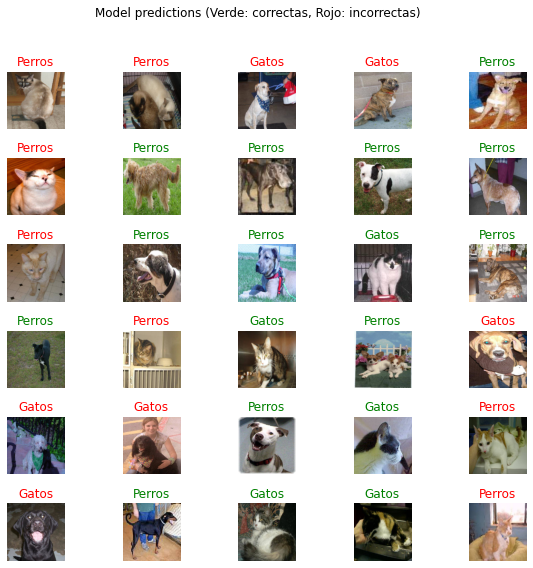

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (Verde: correctas, Rojo: incorrectas)")

En conclusión un modelo ya previamente configurado, como el utilizado en la primera ejecución tiene muy buenos resultados, sin duda mejores que los del segundo, el cual fue construido desde 0, ya que el modelo que ha sido previamente configurado, evidentemente ya cuenta con muchos ajustes que se han ido implementando a lo largo del tiempo, haciendo que dicho modelo sea cada vez más preciso, por lo tanto esta difícil igualar el nivel de accuracy, pero a pesar de apenas tener pequeños acercamientos con modelos de deep learning, siento que al ser el primer modelo de clasificación que construyo, realmente tuvo buenos resultados, que sin duda a medida de más experiencia seguirán mejorando 